Prophet


In [19]:
%pip install prophet
%pip install dtaidistance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from datetime import datetime
import sys

from read_files import read_files

import matplotlib.pyplot as plt

                Abcdin  Falabella  Lider       Paris      Ripley  claro  \
2020-01-10         NaN        NaN    NaN         NaN         NaN    NaN   
2020-01-11         NaN        NaN    NaN         NaN         NaN    NaN   
2020-01-12         NaN        NaN    NaN         NaN         NaN    NaN   
2020-01-13         NaN        NaN    NaN         NaN         NaN    NaN   
2020-01-14         NaN        NaN    NaN         NaN         NaN    NaN   
...                ...        ...    ...         ...         ...    ...   
2021-11-05  181.924861        NaN    NaN  191.021559  200.118257    NaN   
2021-11-06  181.924861        NaN    NaN         NaN  200.118257    NaN   
2021-11-07  181.924861        NaN    NaN         NaN  200.118257    NaN   
2021-11-08  181.924861        NaN    NaN         NaN  200.118257    NaN   
2021-11-09  181.924861        NaN    NaN         NaN         NaN    NaN   

                 entel    movistar  wom  
2020-01-10         NaN  300.181934  NaN  
2020-01-11     

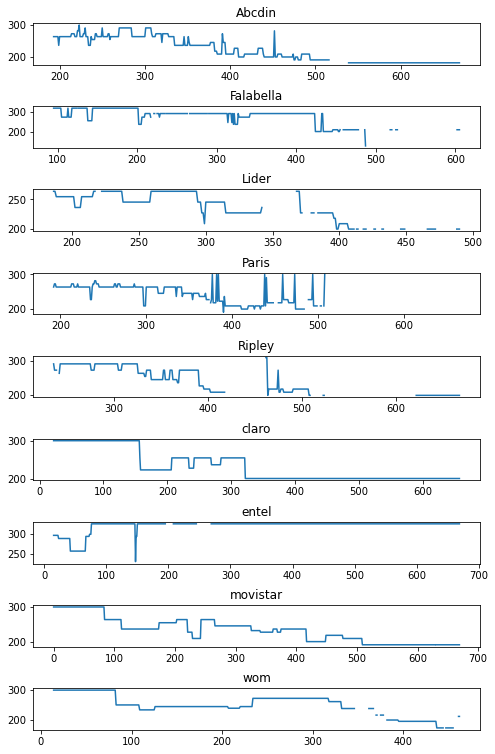

In [21]:
path = "C:/Users/Vasco/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
path = "C:/Users/Vasco Costa/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path

product_group_id = 23 #depende da pasta
time_series_folder = 1 #1,2,3

df_long, df_wide = read_files(path,product_group_id,time_series_folder)
product_information = pd.read_pickle(path+"Data/product_information")
#print(product_information.loc[product_group_id])
print(df_wide)
#print(df_wide.columns)
i = 1
plt.figure(figsize=(8, 13))
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.subplots_adjust(wspace=0.4,
                    hspace=1)
plt.show()

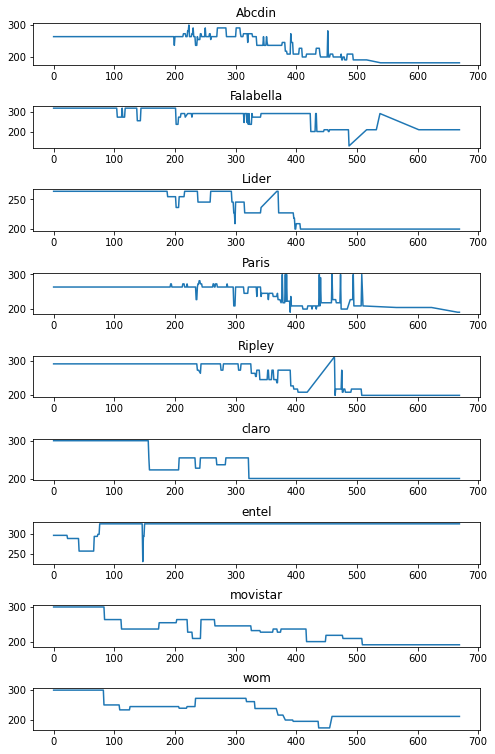

In [22]:
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
          "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[1]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")

i = 1
plt.figure(figsize=(8, 13))
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.subplots_adjust(wspace=0.4,
                    hspace=1)
plt.savefig("product_"+str(product_group_id)+method+".png")
plt.show()

In [23]:
company = "Abcdin"
#company = "movistar"

raw_seq = df_wide[company]


percent_train = 0.7
value = int(len(raw_seq)*percent_train)
train = {"ds":df_wide.index.tolist()[:value],"y":raw_seq[:value]}
test = {"ds":df_wide.index.tolist()[value:],"y":raw_seq[value:]}
train = pd.DataFrame(train)
test = pd.DataFrame(test)


Prophet

In [24]:
m = Prophet()
m.fit(train)

22:49:25 - cmdstanpy - INFO - Chain [1] start processing
22:49:25 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
future = m.make_future_dataframe(periods=len(test))

In [26]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
665,2021-11-05,121.463233,91.806307,150.100842
666,2021-11-06,121.629520,92.185200,151.095710
667,2021-11-07,121.117516,91.687188,148.876781
668,2021-11-08,119.790019,90.342269,150.535454
669,2021-11-09,121.312133,89.813159,151.244139


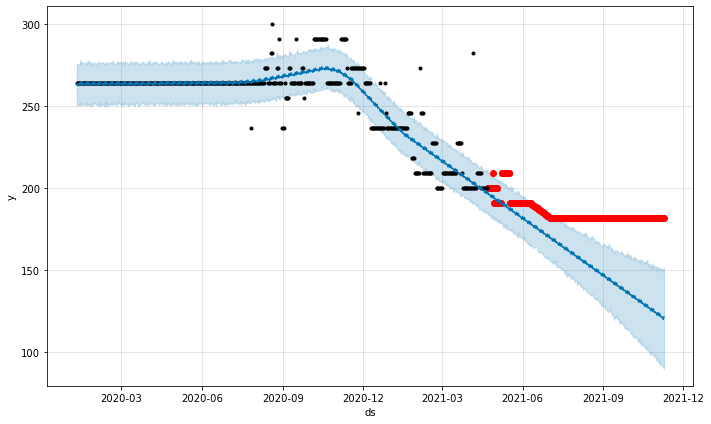

In [27]:
m.plot(forecast)
plt.scatter(test["ds"],test["y"],color="red")
plt.savefig("prophet_"+company+"_default.png")

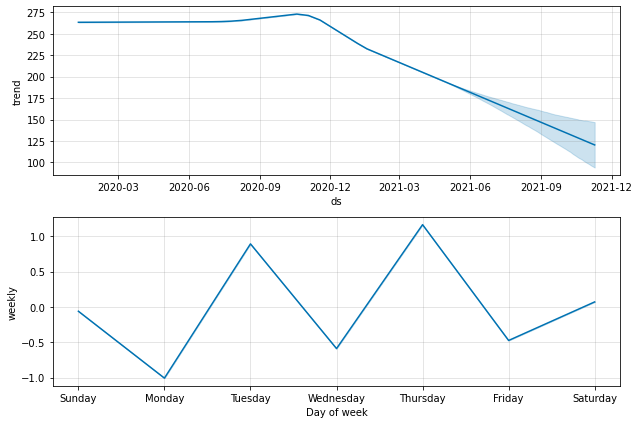

In [28]:
m.plot_components(forecast)
plt.savefig("prophet_"+company+"_default_components.png")

In [29]:
# https://mkang32.github.io/python/2020/12/15/prophet-intro.html#save

ERROR CHECK

In [30]:
import math
import statistics

#para a serie toda
#MAE
yhat = [item for sublist in forecast[['yhat']].values for item in sublist]
print("MAE  : ",sum(yhat - raw_seq)/len(raw_seq))

#MSE
print("MSE  : ",sum((yhat - raw_seq)**2)/len(raw_seq))

#NRMSE
#print("NRMSE: ",math.sqrt(sum((yhat - raw_seq)**2)/len(raw_seq))/(max(raw_seq)-min(raw_seq)) )
print("NRMSE: ",math.sqrt(sum((yhat - raw_seq)**2)/len(raw_seq))/(statistics.mean(raw_seq)) )


MAE  :  -8.265025002462377
MSE  :  387.00725975892783
NRMSE:  0.08440596308696424


In [31]:
#from rdr_scorer import RdR_scorer
#rdr1 = RdR_scorer()
#rdr1.fit(ts = train, 
#         y_colname = "y", 
#         n_step = len(test), 
#         y_true = test, 
#         y_pred = forecast["yhat"][value:], 
##         #model_name = 'Holt-Winters',
#         freq = 12)
#rdr1.score()
# https://github.com/CoteDave/blog/blob/master/RdR%20score/RdR_score_experiment.ipynb

In [32]:
#para o treino
#MAE
yhat = [item for sublist in forecast[['yhat']].values[:value] for item in sublist]
print("MAE  : ",sum(yhat - raw_seq[:value])/len(raw_seq[:value]))

#MSE
print("MSE  : ",sum((yhat - raw_seq[:value])**2)/len(raw_seq))

#NRMSE
#print("NRMSE: ",math.sqrt(sum((yhat - raw_seq)**2)/len(raw_seq))/(max(raw_seq[value:])-min(raw_seq[value:])) )
print("NRMSE: ",math.sqrt(sum((yhat - raw_seq[:value])**2)/len(raw_seq[:value]))/(statistics.mean(raw_seq[:value])) )




#para o teste
#MAE
yhat = [item for sublist in forecast[['yhat']].values[value:] for item in sublist]
print("MAE  : ",sum(yhat - raw_seq[value:])/len(raw_seq[value:]))

#MSE
print("MSE  : ",sum((yhat - raw_seq[value:])**2)/len(raw_seq[value:]))

#NRMSE
#print("NRMSE: ",math.sqrt(sum((yhat - raw_seq)**2)/len(raw_seq))/(max(raw_seq[value:])-min(raw_seq[value:])) )
print("NRMSE: ",math.sqrt(sum((yhat - raw_seq[value:])**2)/len(raw_seq[value:]))/(statistics.mean(raw_seq[value:])) )

MAE  :  0.004380052174131157
MSE  :  66.9816638020966
NRMSE:  0.03864788758974315
MAE  :  -27.423844633996463
MSE  :  1061.4710360944403
NRMSE:  0.1751409549955594


In [33]:
change_point = np.linspace(0.7,0.95,15)
number_change_points = range(20,40,5)
seasonality = [True, False]
percent = np.linspace(0.5, percent_train, 3, endpoint=False)
final = int(len(raw_seq)*percent_train)

best_mse = math.inf
for c in change_point:
    for n in number_change_points:
        for seas in seasonality:
            dic = {}
            for percent_train in percent: #cross validation
                value_1 = int(len(raw_seq)*percent_train)
                train = {"ds":df_wide.index.tolist()[:value_1],"y":raw_seq[:value_1]}
                test = {"ds":df_wide.index.tolist()[final:value_1],"y":raw_seq[final:value_1]}
                train = pd.DataFrame(train)
                test = pd.DataFrame(test)

                m = Prophet(n_changepoints=n,yearly_seasonality=seas,changepoint_range=c)
                m.fit(train)
                future = m.make_future_dataframe(periods=len(test))
                forecast = m.predict(future)
                
                yhat = [item for sublist in forecast[['yhat']].values[final:value_1] for item in sublist]
                mse = sum((yhat - raw_seq[final:value_1])**2)/len(raw_seq)
                dic[percent_train] = mse
            
            mse = sum(dic.values()) / len(dic)
            if mse < best_mse:
                best_mse = mse
                c_best = c
                n_best = n
                seas_best = seas
                best_m = m

22:49:27 - cmdstanpy - INFO - Chain [1] start processing
22:49:27 - cmdstanpy - INFO - Chain [1] done processing
22:49:27 - cmdstanpy - INFO - Chain [1] start processing
22:49:27 - cmdstanpy - INFO - Chain [1] done processing
22:49:28 - cmdstanpy - INFO - Chain [1] start processing
22:49:28 - cmdstanpy - INFO - Chain [1] done processing
22:49:28 - cmdstanpy - INFO - Chain [1] start processing
22:49:28 - cmdstanpy - INFO - Chain [1] done processing
22:49:28 - cmdstanpy - INFO - Chain [1] start processing
22:49:28 - cmdstanpy - INFO - Chain [1] done processing
22:49:29 - cmdstanpy - INFO - Chain [1] start processing
22:49:29 - cmdstanpy - INFO - Chain [1] done processing
22:49:29 - cmdstanpy - INFO - Chain [1] start processing
22:49:29 - cmdstanpy - INFO - Chain [1] done processing
22:49:30 - cmdstanpy - INFO - Chain [1] start processing
22:49:30 - cmdstanpy - INFO - Chain [1] done processing
22:49:30 - cmdstanpy - INFO - Chain [1] start processing
22:49:30 - cmdstanpy - INFO - Chain [1]

In [34]:
train = {"ds":df_wide.index.tolist()[:value],"y":raw_seq[:value]}
test = {"ds":df_wide.index.tolist()[value:],"y":raw_seq[value:]}
train = pd.DataFrame(train)
test = pd.DataFrame(test)

best_m = Prophet(n_changepoints=n_best,yearly_seasonality=seas_best,changepoint_range=c_best)
best_m.fit(train)

22:52:05 - cmdstanpy - INFO - Chain [1] start processing
22:52:06 - cmdstanpy - INFO - Chain [1] done processing
22:52:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
22:52:06 - cmdstanpy - INFO - Chain [1] start processing
22:52:06 - cmdstanpy - INFO - Chain [1] done processing


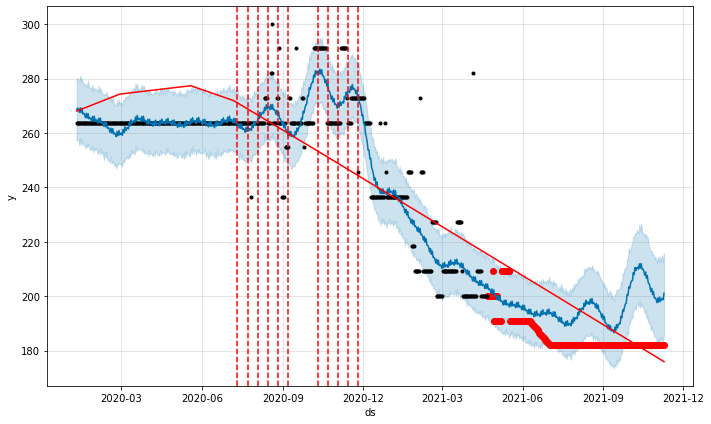

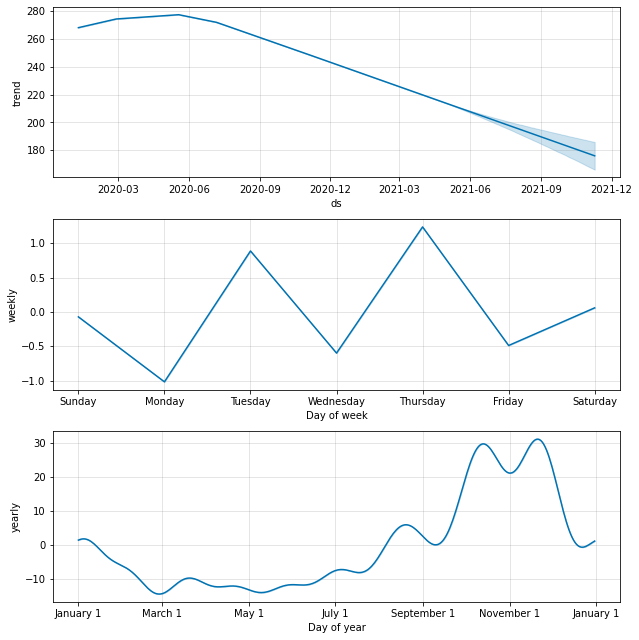

In [35]:
from prophet.plot import add_changepoints_to_plot
future = best_m.make_future_dataframe(periods=len(test))
forecast = best_m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig = best_m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.scatter(test["ds"],test["y"],color="red")
plt.savefig("prophet_"+company+"_best_hyper.png")
best_m.plot_components(forecast)
plt.savefig("prophet_"+company+"_best_hyper_components.png")

In [36]:
#para o treino
#MAE
print("train")
yhat = [item for sublist in forecast[['yhat']].values[:value] for item in sublist]
print("MAE  : ",sum(yhat - raw_seq[:value])/len(raw_seq[:value]))

#MSE
print("MSE  : ",sum((yhat - raw_seq[:value])**2)/len(raw_seq))

#NRMSE
#print("NRMSE: ",math.sqrt(sum((yhat - raw_seq)**2)/len(raw_seq))/(max(raw_seq[value:])-min(raw_seq[value:])) )
print("NRMSE: ",math.sqrt(sum((yhat - raw_seq[:value])**2)/len(raw_seq[:value]))/(statistics.mean(raw_seq[:value])) )


print("test")
#para o teste
#MAE
yhat = [item for sublist in forecast[['yhat']].values[value:] for item in sublist]
print("MAE  : ",sum(yhat - raw_seq[value:])/len(raw_seq[value:]))

#MSE
print("MSE  : ",sum((yhat - raw_seq[value:])**2)/len(raw_seq[value:]))

#NRMSE
#print("NRMSE: ",math.sqrt(sum((yhat - raw_seq)**2)/len(raw_seq))/(max(raw_seq[value:])-min(raw_seq[value:])) )
print("NRMSE: ",math.sqrt(sum((yhat - raw_seq[value:])**2)/len(raw_seq[value:]))/(statistics.mean(raw_seq[value:])) )

train
MAE  :  -6.026284743405019e-05
MSE  :  54.584434352703134
NRMSE:  0.03488849237667234
test
MAE  :  10.58318993855228
MSE  :  188.04401769059044
NRMSE:  0.0737162781627592
